In [1]:
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.parsers.constants import EXTENSIONS
import pandas as pd

from peak_pack.fgen import (
    PeakFeatures,
    ExplainedIntensityFeatures,
    MissingFragmentationFeatures,
    PPMFeatures,
    HyperscoreGenerator,
    PeakFeatureGenerator
)

from ms2rescore.feature_generators.basic import BasicFeatureGenerator
from ms2rescore.feature_generators.ms2pip import MS2PIPFeatureGenerator
from ms2rescore.feature_generators.deeplc import DeepLCFeatureGenerator

from ms2rescore import rescore, parse_configurations

from pyteomics import mgf
import os
from glob import glob

from rustyms import RawSpectrum, LinearPeptide, FragmentationModel

Modification already exists in ModificationsDB. Skipping.


2024-10-03 11:03:04.450086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 11:03:04.458787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 11:03:04.461417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1727946185.373659 1953574 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# PARAMETER SETTING
root_ground_truth = "/home/samva/Doctorate/data_directory/PXD028735/search_results/identification"
root_denovo_results = "/home/samva/Doctorate/data_directory/PXD028735/denovo_results"
root_mgf = "/home/samva/Doctorate/data_directory/PXD028735/mgf/Orbitrap_QE/reformatted"
root_out = "/home/samva/Doctorate/data_directory/PXD028735/denovo_results/merged2"
engines = [
    "casanovo",
    "instanovo",
    "contranovo",
    "pepnet",
    "novob"
]

NEUTRAL_LOSSES = [
    "-H2O1",
    ""
]

ion_types = [
    'a1',
    'a2',
    'b1',
    'b2',
    'c1',
    'c2',
    'y1',
    'y2',
    'z1',
    'z2',
    'x1',
    'x2',
    'p1',
    'p2',
    'p3'
    # 'w1',
    # 'w2',
    # 'v1',
    # 'v2',
    # 'd1',
    # 'd2'
]

config = {
    # For peak annotation
    "ion_types": ion_types,
    "neutral_losses": NEUTRAL_LOSSES,
    "max_workers": 18,
    # For evidence object
    "ion_types_evidence": ["b1", "y1", "b2", "y2"],
    "neutral_losses_evidence": ["", "-H2O1"],
    # For hyperscore calculation
    "fragment_tol_mass": 20,
    "fragment_tol_mode": "ppm"
}

In [3]:
mgf_psm_dict = {}

for mgf_path in glob(os.path.join(root_mgf, "*.mgf")):
    ground_truth_filetype = "sage"
    filename = os.path.basename(mgf_path).split(".")[0]
    mgf_psm_dict[filename] = {
        "psm_file": os.path.join(root_ground_truth, filename + EXTENSIONS[ground_truth_filetype]),
        "spectrum_path": mgf_path

    }
    parser = DenovoEngineConverter.select(ground_truth_filetype)
    psm_list = parser.parse(
        os.path.join(root_ground_truth, filename + EXTENSIONS[ground_truth_filetype]),
        mgf_path=mgf_path
    )
    
    # Only keep first rank psms
    psm_list = psm_list.get_rank1_psms()
    break

# # Get raw spectrum
mgf_file = mgf.read(mgf_path)
# spec = mgf_file.get_by_id(ground_truth_psmlist[0].spectrum_id)

# # Get associated PSM
# psm = ground_truth_psmlist[0]
# int(psm["spectrum_id"].split("=")[-1])

In [4]:
len(psm_list)

90817

In [4]:
# n = 5000
# mgf_spectra = mgf_file.get_by_ids([psm.spectrum_id for psm in ground_truth_psmlist[:n]])
# sliced_psmlist = ground_truth_psmlist[:n]
# sliced_mgf = mgf_spectra[:n]

In [5]:
peak_fgen = PeakFeatures()
missing_fgen = MissingFragmentationFeatures()
hyperscore_fgen = HyperscoreGenerator(config=config)
ppm_fgen = PPMFeatures()
explained_fgen = ExplainedIntensityFeatures()

all_fgens = PeakFeatureGenerator(
    feature_generators=[
        peak_fgen,
        missing_fgen,
        hyperscore_fgen,
        ppm_fgen,
        explained_fgen
    ],
    config=config
)

In [6]:
all_fgens.add_features(
    psm_list=psm_list,
    mgf_file=mgf_file
)

100%|██████████| 90817/90817 [06:18<00:00, 240.20it/s]
90817it [00:00, 91323.66it/s] 
20182it [00:02, 9212.94it/s]

54896it [00:06, 9135.09it/s]

90817it [00:10, 9021.13it/s]
90817it [00:04, 19967.70it/s]


In [7]:
import json
path_config_ms2rescore = "/home/samva/Doctorate/DeNovo_Benchmark/configs/ms2rescore/ms2rescore_config.json"

with open(path_config_ms2rescore) as config_file:
    configuration = json.load(config_file)

configuration["ms2rescore"]["psm_file"] = mgf_psm_dict["LFQ_Orbitrap_DDA_Human_01"]["psm_file"]
configuration["ms2rescore"]["spectrum_path"] = mgf_psm_dict["LFQ_Orbitrap_DDA_Human_01"]["spectrum_path"]
configuration = parse_configurations(configurations=configuration)

In [8]:
import json
import logging
from multiprocessing import cpu_count
from typing import Dict, Optional

import numpy as np
import psm_utils.io
from mokapot.dataset import LinearPsmDataset
from psm_utils import PSMList


from ms2rescore import exceptions
from ms2rescore.feature_generators import FEATURE_GENERATORS
from ms2rescore.parse_psms import parse_psms
from ms2rescore.parse_spectra import get_missing_values
from ms2rescore.report import generate
from ms2rescore.rescoring_engines import mokapot, percolator
from ms2rescore.rescoring_engines.mokapot import add_peptide_confidence, add_psm_confidence
from ms2rescore.core import _log_id_psms_after, _log_id_psms_before, _fill_missing_precursor_info, _write_feature_names

import logging
logger = logging.getLogger(__name__)

def prepare_for_ms2rescore(configuration, psm_list):
    """
    Run full MS²Rescore workflow with passed configuration.

    Parameters
    ----------
    configuration
        Dictionary containing ms2rescore configuration.
    psm_list
        PSMList object containing PSMs. If None, PSMs will be read from configuration ``psm_file``.

    """
    logger.debug(
        f"Running MS²Rescore with following configuration: {json.dumps(configuration, indent=4)}"
    )
    config = configuration["ms2rescore"]
    output_file_root = config["output_path"]

    # Write full configuration including defaults to file
    with open(output_file_root + ".full-config.json", "w") as f:
        json.dump(configuration, f, indent=4)

    logger.debug("Using %i of %i available CPUs.", int(config["processes"]), int(cpu_count()))

    # Parse PSMs
    psm_list = parse_psms(config, psm_list)

    # Log #PSMs identified before rescoring
    id_psms_before = _log_id_psms_before(psm_list, max_rank=config["max_psm_rank_output"])

    # Define feature names; get existing feature names from PSM file
    feature_names = dict()
    psm_list_feature_names = {
        feature_name
        for psm_list_features in psm_list["rescoring_features"]
        for feature_name in psm_list_features.keys()
    }
    feature_names["psm_file"] = psm_list_feature_names
    logger.debug(
        f"PSMs already contain the following rescoring features: {psm_list_feature_names}"
    )

    # Add missing precursor info from spectrum file if needed
    psm_list = _fill_missing_precursor_info(psm_list, config)

    # Add rescoring features
    for fgen_name, fgen_config in config["feature_generators"].items():
        # TODO: Handle this somewhere else, more generally?
        if fgen_name == "maxquant" and not (psm_list["source"] == "msms").all():
            logger.warning(
                "MaxQuant feature generator requires PSMs from a MaxQuant msms.txt file. Skipping "
                "this feature generator."
            )
            continue
        conf = config.copy()
        conf.update(fgen_config)
        fgen = FEATURE_GENERATORS[fgen_name](**conf)
        fgen.add_features(psm_list)
        logger.debug(f"Adding features from {fgen_name}: {set(fgen.feature_names)}")
        feature_names[fgen_name] = set(fgen.feature_names)

    # Filter out psms that do not have all added features
    all_feature_names = {f for fgen in feature_names.values() for f in fgen}
    psms_with_features = [
        (set(psm.rescoring_features.keys()) == all_feature_names) for psm in psm_list
    ]

    if psms_with_features.count(False) > 0:
        removed_psms = psm_list[[not psm for psm in psms_with_features]]
        missing_features = {
            feature_name
            for psm in removed_psms
            for feature_name in all_feature_names - set(psm.rescoring_features.keys())
        }
        logger.warning(
            f"Removed {psms_with_features.count(False)} PSMs that were missing one or more "
            f"rescoring feature(s), {missing_features}."
        )
    psm_list = psm_list[psms_with_features]

    # Write feature names to file
    _write_feature_names(feature_names, output_file_root)

    if config["rename_to_usi"]:
        logging.debug(f"Creating USIs for {len(psm_list)} PSMs")
        psm_list["spectrum_id"] = [psm.get_usi(as_url=False) for psm in psm_list]

    # If no rescoring engine is specified or DEBUG, write PSMs and features to PIN file
    if not config["rescoring_engine"] or config["log_level"] == "debug":
        logger.info(f"Writing added features to PIN file: {output_file_root}.psms.pin")
        psm_utils.io.write_file(
            psm_list,
            output_file_root + ".pin",
            filetype="percolator",
            feature_names=all_feature_names,
        )

    if not config["rescoring_engine"]:
        logger.info("No rescoring engine specified. Skipping rescoring.")
        return None
    
    # Rescore PSMs
    try:
        if "percolator" in config["rescoring_engine"]:
            percolator.rescore(
                psm_list,
                output_file_root=output_file_root,
                log_level=config["log_level"],
                processes=config["processes"],
                percolator_kwargs=config["rescoring_engine"]["percolator"],
            )
        elif "mokapot" in config["rescoring_engine"]:
            if "fasta_file" not in config["rescoring_engine"]["mokapot"]:
                config["rescoring_engine"]["mokapot"]["fasta_file"] = config["fasta_file"]
            if "protein_kwargs" in config["rescoring_engine"]["mokapot"]:
                protein_kwargs = config["rescoring_engine"]["mokapot"].pop("protein_kwargs")
            else:
                protein_kwargs = dict()

            mokapot.rescore(
                psm_list,
                output_file_root=output_file_root,
                protein_kwargs=protein_kwargs,
                **config["rescoring_engine"]["mokapot"],
            )
    except exceptions.RescoringError as e:
        # Write output
        logger.info(f"Writing intermediary output to {output_file_root}.psms.tsv...")
        psm_utils.io.write_file(psm_list, output_file_root + ".psms.tsv", filetype="tsv")

        # Reraise exception
        raise e

    # Post-rescoring processing
    if all(psm_list["pep"] == 1.0):
        psm_list = _fix_constant_pep(psm_list)
    psm_list = _filter_by_rank(psm_list, config["max_psm_rank_output"], False)
    psm_list = _calculate_confidence(psm_list)
    _ = _log_id_psms_after(psm_list, id_psms_before, max_rank=config["max_psm_rank_output"])

    # Write output
    logger.info(f"Writing output to {output_file_root}.psms.tsv...")
    psm_utils.io.write_file(psm_list, output_file_root + ".psms.tsv", filetype="tsv")

    # Write report
    if config["write_report"]:
        try:
            generate.generate_report(
                output_file_root, psm_list=psm_list, feature_names=feature_names, use_txt_log=True
            )
        except exceptions.ReportGenerationError as e:
            logger.exception(e)

In [9]:
mokapot_models = rescore(
    configuration=configuration,
    psm_list=psm_list
)

I0000 00:00:1727946688.508073 1953574 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [47]:
f = pd.DataFrame(psm_list["rescoring_features"].tolist())

In [59]:
psm_df = psm_list.to_dataframe()

In [98]:
from mokapot.model import load_model

pd.read_csv(
    "/home/samva/Doctorate/data_directory/PXD028735/search_results/identification/LFQ_Orbitrap_DDA_Human_01.sage.ms2rescore.mokapot.weights.tsv", sep="\t"
)

,feature:expmass,feature:calcmass,feature:peptide_len,feature:missed_cleavages,feature:isotope_error,feature:precursor_ppm,feature:fragment_ppm,feature:hyperscore,feature:delta_next,feature:delta_best,...,feature:dotprod_iony,feature:cos,feature:cos_ionb,feature:cos_iony,feature:observed_retention_time,feature:predicted_retention_time,feature:rt_diff,feature:observed_retention_time_best,feature:predicted_retention_time_best,feature:rt_diff_best
0,0.225447,0.220862,-0.400429,-0.627337,-0.012741,0.019645,-0.081800,1.060652,0.171384,0.0,...,-0.037753,0.393623,-0.111518,0.165901,0.057673,0.405021,0.401568,-0.787352,0.405022,-2.436539
1,0.171525,0.170638,-0.548483,-0.508463,-0.049892,0.026079,-0.054677,0.958225,0.178326,0.0,...,-0.054087,0.092793,0.023795,0.317537,0.128741,0.308068,0.057605,-0.868036,0.308068,-2.049232
2,0.260000,0.258836,-0.700640,-0.629554,-0.090395,0.006858,-0.049977,1.032647,0.184490,0.0,...,-0.039157,0.298893,-0.052068,0.067012,0.082335,0.306643,0.443507,-0.782699,0.306643,-2.415326


In [78]:
indices = psm_df[
    (psm_df.qvalue < .01) &
    (~psm_df.is_decoy)
].index

In [85]:
psm_df.provenance_data[0]

{'sage_filename': '/home/samva/Doctorate/data_directory/PXD028735/search_results/identification/LFQ_Orbitrap_DDA_Human_01.sage.tsv',
 'before_rescoring_score': 1.477149,
 'before_rescoring_qvalue': 3.475239e-05,
 'before_rescoring_pep': None,
 'before_rescoring_rank': 1}

In [90]:
psm_df["prev_score"] = psm_df["provenance_data"].apply(lambda x: x["before_rescoring_score"])
psm_df["prev_qval"] = psm_df["provenance_data"].apply(lambda x: x["before_rescoring_qvalue"])

In [91]:
len(psm_df.iloc[psm_df[(psm_df.qvalue < .01) & (~psm_df.is_decoy)].index])

85694

In [93]:
len(psm_df.iloc[psm_df[(psm_df.prev_qval < .01) & (~psm_df.is_decoy)].index])

74408

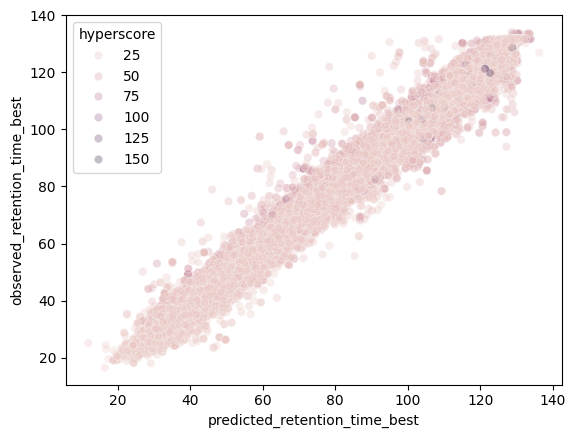

In [65]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


sns.scatterplot(
    f.iloc[indices],
    x="predicted_retention_time_best",
    y="observed_retention_time_best",
    hue="hyperscore",
    alpha=.3
)
plt.show()

<Axes: xlabel='spec_pearson', ylabel='Density'>

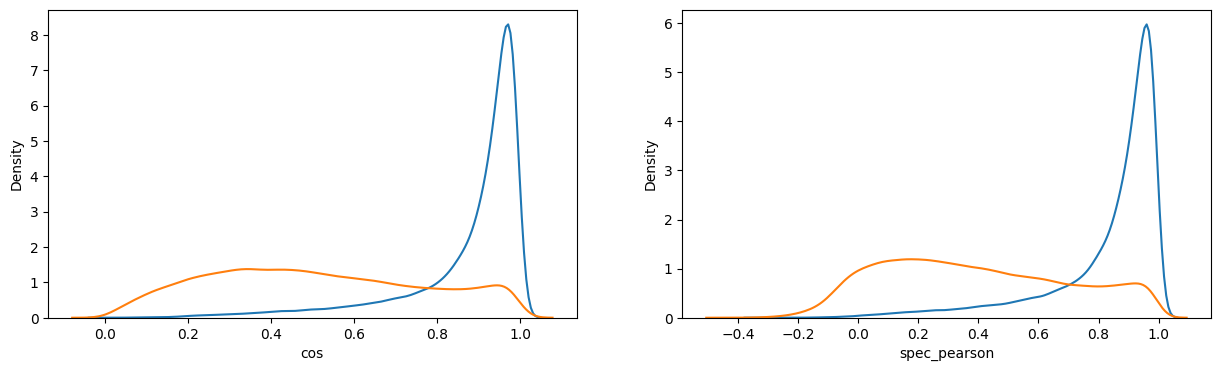

In [74]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

sns.kdeplot(
    f.iloc[indices],
    x="cos",
    ax=ax[0]
)
sns.kdeplot(
    f.iloc[~f.index.isin(indices)],
    x="cos",
    ax=ax[0],
    label="decoy"
)

sns.kdeplot(
    f.iloc[indices],
    x="spec_pearson",
    ax=ax[1]
)
sns.kdeplot(
    f.iloc[~f.index.isin(indices)],
    x="spec_pearson",
    ax=ax[1],
    label="decoy"
)

In [ ]:
ms2pip_fgen = MS2PIPFeatureGenerator(
    model="HCD"
)

In [7]:
df = pd.DataFrame(sliced_psmlist["rescoring_features"].tolist())